In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

from tensorflow import keras
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yseon\Anaconda3\envs\bengali\lib\site-packages\tensorflow\

In [3]:
!

In [4]:
train_df_ = pd.read_csv('bengaliai-cv19/train.csv')
test_df_ = pd.read_csv('bengaliai-cv19/test.csv')
class_map_df = pd.read_csv('bengaliai-cv19/class_map.csv')
sample_sub_df = pd.read_csv('bengaliai-cv19/sample_submission.csv')

In [5]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [6]:
test_df_.head()

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root


In [7]:
print(class_map_df.head())
class_map_df['component_type'].value_counts()

  component_type  label component
0  grapheme_root      0         ং
1  grapheme_root      1         ঃ
2  grapheme_root      2         অ
3  grapheme_root      3         আ
4  grapheme_root      4         ই


grapheme_root          168
vowel_diacritic         11
consonant_diacritic      7
Name: component_type, dtype: int64

In [8]:
class_map_df[class_map_df['label']==9]

,component_type,label,component
9,grapheme_root,9,এ
177,vowel_diacritic,9,ো


In [9]:
train_df_.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


## EDA

In [10]:
HEIGHT = 236
WIDTH = 236

# def get_n(df, field, n, top = True):
    

In [11]:
HEIGHT = 236
WIDTH = 236

def get_n(df, field, n, top=True):
    top_graphemes = df.groupby([field]).size().reset_index(name='counts')['counts'].sort_values(ascending=not top)[:n]
    top_grapheme_roots = top_graphemes.index
    top_grapheme_counts = top_graphemes.values
    top_graphemes = class_map_df[class_map_df['component_type'] == field].reset_index().iloc[top_grapheme_roots]
    top_graphemes.drop(['component_type', 'label'], axis=1, inplace=True)
    top_graphemes.loc[:, 'count'] = top_grapheme_counts
    return top_graphemes

def image_from_char(char):
    image = Image.new('RGB', (WIDTH, HEIGHT))
    draw = ImageDraw.Draw(image)
    myfont = ImageFont.truetype('bengaliai-cv19/kalpurush-2.ttf', 120)
    w, h = draw.textsize(char, font=myfont)
    draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 3), char, font=myfont)

    return image

     index component  count
72      72         দ   5736
64      64         ত   5596
13      13         ক   5420
107    107         ব   5321
23      23         গ   5149
96      96         প   4926
113    113         ভ   4395
147    147         স   4392
133    133         শ   4374
115    115         ম   4015


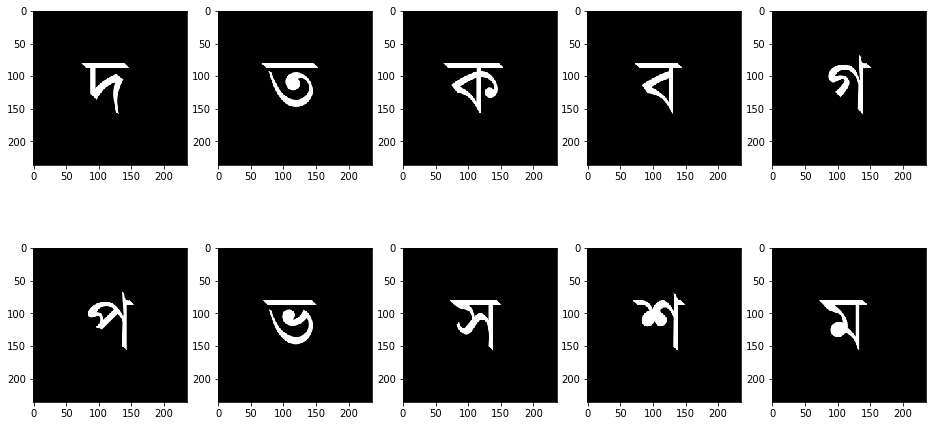

In [12]:
# Grapheme_root
top_10_roots = get_n(train_df_, 'grapheme_root', 10)
print(top_10_roots)

f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(top_10_roots['component'].iloc[i]), cmap='Greys')

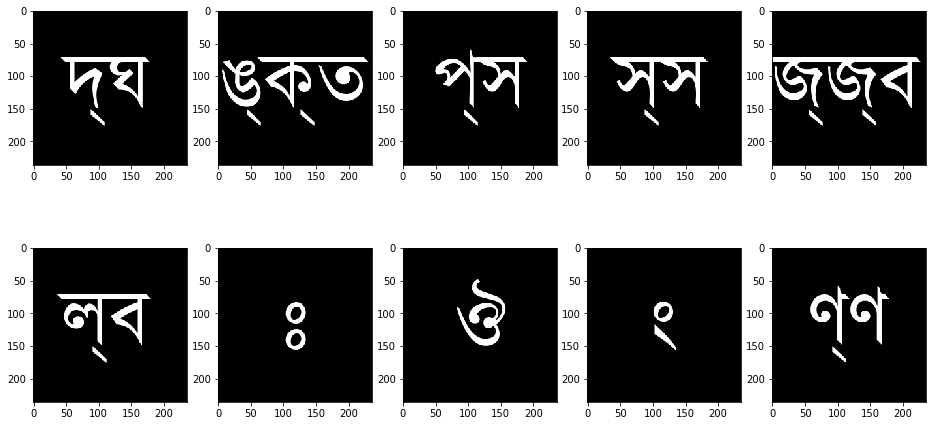

In [13]:
bottom_10_roots = get_n(train_df_, 'grapheme_root', 10, False)
bottom_10_roots
f, ax = plt.subplots(2, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(10):
    ax[i].imshow(image_from_char(bottom_10_roots['component'].iloc[i]), cmap='Greys')

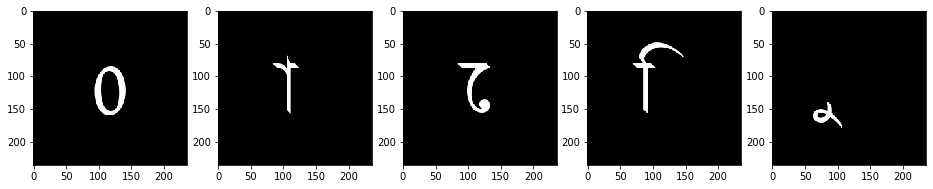

In [14]:
top_5_vowels = get_n(train_df_, 'vowel_diacritic', 5)
top_5_vowels
f, ax = plt.subplots(1, 5, figsize=(16, 8))
ax = ax.flatten()

for i in range(5):
    ax[i].imshow(image_from_char(top_5_vowels['component'].iloc[i]), cmap='Greys')

In [15]:
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

In [16]:
train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']] = train_df_[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].astype('uint8')

In [17]:
IMG_SIZE=128
N_CHANNELS = 1

In [18]:
# Image Processing while resizing the images, 
# center crop
def resize(df, size=128, need_progress_bar=True):
    resized = {}
    resize_size=128
    if need_progress_bar:
        for i in tqdm(range(df.shape[0])):
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    else:
        for i in range(df.shape[0]):
            #image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size),None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
            image=df.loc[df.index[i]].values.reshape(137,236)
            _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

            idx = 0 
            ls_xmin = []
            ls_ymin = []
            ls_xmax = []
            ls_ymax = []
            for cnt in contours:
                idx += 1
                x,y,w,h = cv2.boundingRect(cnt)
                ls_xmin.append(x)
                ls_ymin.append(y)
                ls_xmax.append(x + w)
                ls_ymax.append(y + h)
            xmin = min(ls_xmin)
            ymin = min(ls_ymin)
            xmax = max(ls_xmax)
            ymax = max(ls_ymax)

            roi = image[ymin:ymax,xmin:xmax]
            resized_roi = cv2.resize(roi, (resize_size, resize_size),interpolation=cv2.INTER_AREA)
            resized[df.index[i]] = resized_roi.reshape(-1)
    resized = pd.DataFrame(resized).T
    return resized

In [19]:
def get_dummies(df):
    cols = []
    for col in df:
        cols.append(pd.get_dummies(df[col].astype(str)))
    return pd.concat(cols, axis=1)

# Basic Model

In [20]:
inputs = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=128, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2, 2))(model)
model = Conv2D(filters=256, kernel_size=(5, 5), padding='SAME', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)

model = Flatten()(model)
model = Dense(1024, activation = "relu")(model)
model = Dropout(rate=0.3)(model)
dense = Dense(512, activation = "relu")(model)

head_root = Dense(168, activation = 'softmax')(dense)
head_vowel = Dense(11, activation = 'softmax')(dense)
head_consonant = Dense(7, activation = 'softmax')(dense)

model = Model(inputs=inputs, outputs=[head_root, head_vowel, head_consonant])

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_2[0][0]                   
____________________________________________________________________________________________

In [19]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction_root = ReduceLROnPlateau(monitor='dense_3_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_vowel = ReduceLROnPlateau(monitor='dense_4_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)
learning_rate_reduction_consonant = ReduceLROnPlateau(monitor='dense_5_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
batch_size = 256
epochs = 30

In [24]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=200,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,
                                         shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [25]:
HEIGHT = 137
WIDTH = 236

In [26]:
# # from tensorflow.python.client import device_lib

# # print(device_lib.list_local_devices())

# from keras import backend as K

# K.tensorflow_backend._get_available_gpus()



In [27]:
# from keras.backend.tensorflow_backend import set_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import get_session
# import tensorflow

# # Reset Keras Session
# def reset_keras():
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

#     try:
#         del classifier # this is from global space - change this as you need
#     except:
#         pass

#     print(gc.collect()) # if it's done something you should see a number being outputted

#     # use the same config as you used to create the session
#     config = tensorflow.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = 1
#     config.gpu_options.visible_device_list = "0"
#     set_session(tensorflow.Session(config=config))
# reset_keras()

In [28]:
# ## LIMIT GPU USAGE
# import tensorflow as tf
# from keras import backend as K
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True  # don't pre-allocate memory; allocate as-needed
# config.gpu_options.per_process_gpu_memory_fraction = 0.95  # limit memory to be allocated
# K.tensorflow_backend.set_session(tf.Session(config=config)) # create sess w/ above settings

In [ ]:
histories = []

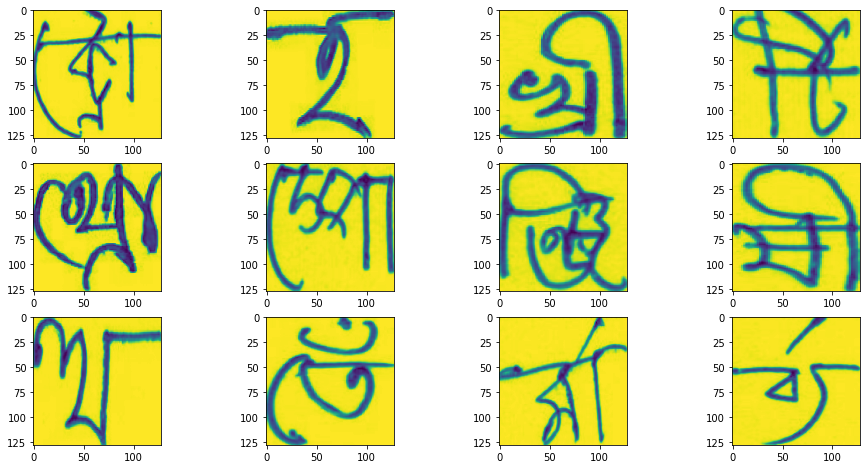


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)

Epoch 1/30
180/180 [==============================] - 87s 482ms/step - loss: 7.8758 - dense_3_loss: 4.7906 - dense_4_loss: 1.8341 - dense_5_loss: 1.2511 - dense_3_accuracy: 0.0296 - dense_4_accuracy: 0.3725 - dense_5_accuracy: 0.6250 - val_loss: 6.8516 - val_dense_3_loss: 4.4901 - val_dense_4_loss: 1.3831 - val_dense_5_loss: 0.9782 - val_dense_3_accuracy: 0.0490 - val_dense_4_accuracy: 0.4712 - val_dense_5_accuracy: 0.6547
Epoch 2/30
180/180 [==============================] - 82s 457ms/step - loss: 6.5061 - dense_3_loss: 4.3535 - dense_4_loss: 1.1955 - dense_5_loss: 0.9572 - dense_3_accuracy: 0.0509 - dense_4_accuracy: 0.5864 - dense_5_accuracy: 0.6712 - val_loss: 5.4659 - val_dense_3_loss: 3.9713 - val_dense_4_loss: 0.7575 - val_dense_5_loss: 0.7411 - val_dense_3_accuracy: 0.0804 - val_dense_4_accuracy: 0.7498 - val_dense_5_accuracy: 0.74

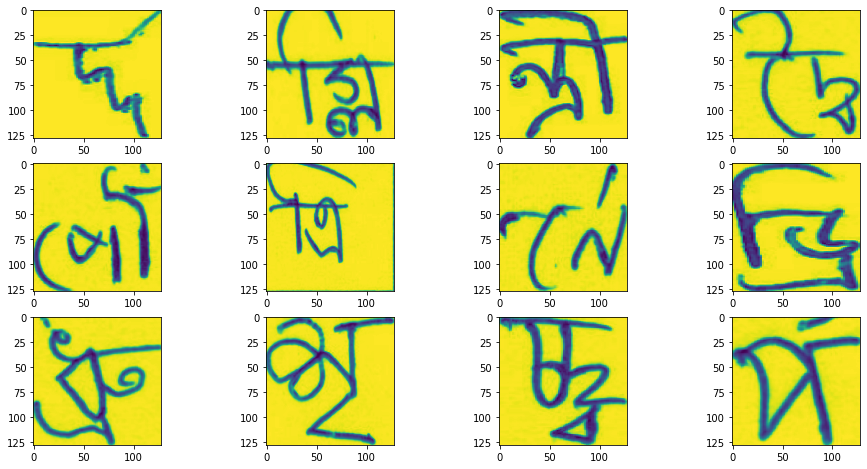


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 81s 452ms/step - loss: 1.0021 - dense_3_loss: 0.5786 - dense_4_loss: 0.2461 - dense_5_loss: 0.1775 - dense_3_accuracy: 0.8422 - dense_4_accuracy: 0.9289 - dense_5_accuracy: 0.9467 - val_loss: 0.4749 - val_dense_3_loss: 0.2925 - val_dense_4_loss: 0.0982 - val_dense_5_loss: 0.0822 - val_dense_3_accuracy: 0.9166 - val_dense_4_accuracy: 0.9749 - val_dense_5_accuracy: 0.9783
Epoch 2/30
180/180 [==============================] - 81s 447ms/step - loss: 0.8781 - dense_3_loss: 0.4921 - dense_4_loss: 0.2281 - dense_5_loss: 0.1580 - dense_3_accuracy: 0.8626 - dense_4_accuracy: 0.9331 - dense_5_accuracy: 0.9517 - val_loss: 0.4473 - val_dense_3_loss: 0.2741 - val_dense_4_loss: 0.0917 - val_dense_5_loss: 0.0806 - val_dense_3_accuracy: 0.9203 - val_dense_4_accuracy: 0.9754 - val_dense_5_accuracy: 0.977

Epoch 20/30
180/180 [==============================] - 80s 445ms/step - loss: 0.4715 - dense_3_loss: 0.2379 - dense_4_loss: 0.1397 - dense_5_loss: 0.0939 - dense_3_accuracy: 0.9277 - dense_4_accuracy: 0.9589 - dense_5_accuracy: 0.9706 - val_loss: 0.4476 - val_dense_3_loss: 0.2726 - val_dense_4_loss: 0.0931 - val_dense_5_loss: 0.0834 - val_dense_3_accuracy: 0.9283 - val_dense_4_accuracy: 0.9751 - val_dense_5_accuracy: 0.9798
Epoch 21/30
180/180 [==============================] - 81s 447ms/step - loss: 0.4554 - dense_3_loss: 0.2273 - dense_4_loss: 0.1366 - dense_5_loss: 0.0915 - dense_3_accuracy: 0.9311 - dense_4_accuracy: 0.9586 - dense_5_accuracy: 0.9722 - val_loss: 0.4266 - val_dense_3_loss: 0.2607 - val_dense_4_loss: 0.0892 - val_dense_5_loss: 0.0760 - val_dense_3_accuracy: 0.9343 - val_dense_4_accuracy: 0.9759 - val_dense_5_accuracy: 0.9768
Epoch 22/30
180/180 [==============================] - 80s 447ms/step - loss: 0.4503 - dense_3_loss: 0.2234 - dense_4_loss: 0.1378 - dense_5_los

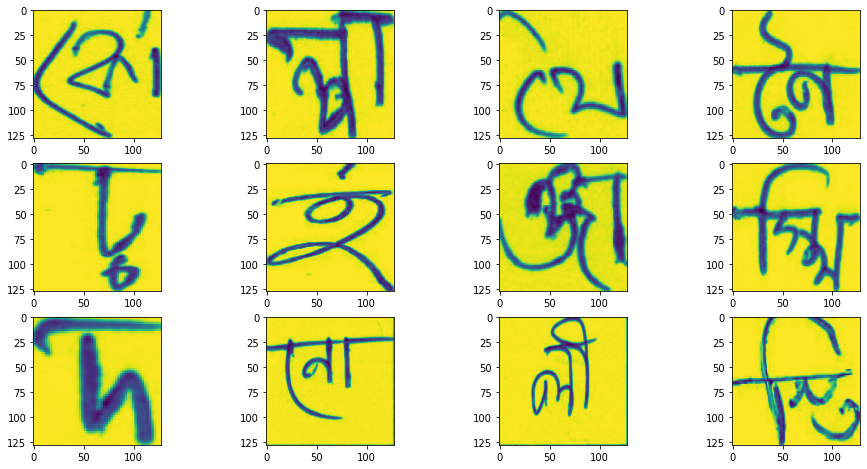


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 81s 452ms/step - loss: 0.7677 - dense_3_loss: 0.4424 - dense_4_loss: 0.1857 - dense_5_loss: 0.1395 - dense_3_accuracy: 0.8814 - dense_4_accuracy: 0.9462 - dense_5_accuracy: 0.9585 - val_loss: 0.4387 - val_dense_3_loss: 0.2635 - val_dense_4_loss: 0.0995 - val_dense_5_loss: 0.0792 - val_dense_3_accuracy: 0.9325 - val_dense_4_accuracy: 0.9709 - val_dense_5_accuracy: 0.9773
Epoch 2/30
180/180 [==============================] - 80s 446ms/step - loss: 0.6350 - dense_3_loss: 0.3484 - dense_4_loss: 0.1656 - dense_5_loss: 0.1210 - dense_3_accuracy: 0.9018 - dense_4_accuracy: 0.9517 - dense_5_accuracy: 0.9628 - val_loss: 0.3905 - val_dense_3_loss: 0.2474 - val_dense_4_loss: 0.0730 - val_dense_5_loss: 0.0734 - val_dense_3_accuracy: 0.9343 - val_dense_4_accuracy: 0.9816 - val_dense_5_accuracy: 0.976


Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 20/30
180/180 [==============================] - 81s 448ms/step - loss: 0.2751 - dense_3_loss: 0.1306 - dense_4_loss: 0.0900 - dense_5_loss: 0.0545 - dense_3_accuracy: 0.9602 - dense_4_accuracy: 0.9736 - dense_5_accuracy: 0.9827 - val_loss: 0.3616 - val_dense_3_loss: 0.2311 - val_dense_4_loss: 0.0599 - val_dense_5_loss: 0.0725 - val_dense_3_accuracy: 0.9482 - val_dense_4_accuracy: 0.9851 - val_dense_5_accuracy: 0.9801
Epoch 21/30
180/180 [==============================] - 82s 456ms/step - loss: 0.2464 - dense_3_loss: 0.1127 - dense_4_loss: 0.0827 - dense_5_loss: 0.0510 - dense_3_accuracy: 0.9645 - dense_4_accuracy: 0.9755 - dense_5_accuracy: 0.9842 - val_loss: 0.3897 - val_dense_3_loss: 0.2334 - val_dense_4_loss: 0.0769 - val_dense_5_loss: 0.0831 - val_dense_3_accuracy: 0.9477 - val_dense_4_accuracy: 0.9788 - val_dense_5_accuracy: 0.9771
Epoch 22/30
180/180 [==============================] - 81s 449m

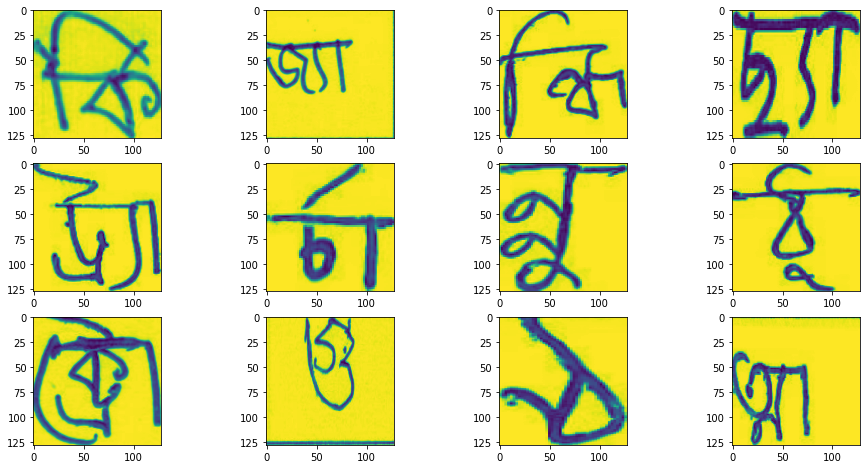


Training images: (50210, 128, 128, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
Epoch 1/30
180/180 [==============================] - 82s 453ms/step - loss: 0.5687 - dense_3_loss: 0.3255 - dense_4_loss: 0.1414 - dense_5_loss: 0.1019 - dense_3_accuracy: 0.9155 - dense_4_accuracy: 0.9605 - dense_5_accuracy: 0.9703 - val_loss: 0.3040 - val_dense_3_loss: 0.1789 - val_dense_4_loss: 0.0717 - val_dense_5_loss: 0.0542 - val_dense_3_accuracy: 0.9502 - val_dense_4_accuracy: 0.9826 - val_dense_5_accuracy: 0.9846
Epoch 2/30
180/180 [==============================] - 80s 445ms/step - loss: 0.4790 - dense_3_loss: 0.2666 - dense_4_loss: 0.1211 - dense_5_loss: 0.0913 - dense_3_accuracy: 0.9264 - dense_4_accuracy: 0.9654 - dense_5_accuracy: 0.9735 - val_loss: 0.2866 - val_dense_3_loss: 0.1756 - val_dense_4_loss: 0.0650 - val_dense_5_loss: 0.0463 - val_dense_3_accuracy: 0.9487 - val_dense_4_accuracy: 0.9831 - val_dense_5_accuracy: 0.987

KeyboardInterrupt: 

In [29]:

for i in range(4):
#     if i <3: continue
#     print(i)
    train_df = pd.merge(pd.read_parquet(f'bengaliai-cv19/train_image_data_{i}.parquet'), train_df_, on='image_id').drop(['image_id'], axis=1)
    
    # Visualize few samples of current training dataset
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))
    count=0
    for row in ax:
        for col in row:
            col.imshow(resize(train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1).iloc[[count]], need_progress_bar=False).values.reshape(-1).reshape(IMG_SIZE, IMG_SIZE).astype(np.float64))
            count += 1
    plt.show()
    
    X_train = train_df.drop(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic'], axis=1)
    X_train = resize(X_train)/255
    
    # CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images
    X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    
    Y_train_root = pd.get_dummies(train_df['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df['vowel_diacritic']).values
    Y_train_consonant = pd.get_dummies(train_df['consonant_diacritic']).values

    print(f'Training images: {X_train.shape}')
    print(f'Training labels root: {Y_train_root.shape}')
    print(f'Training labels vowel: {Y_train_vowel.shape}')
    print(f'Training labels consonants: {Y_train_consonant.shape}')

    # Divide the data into training and validation set
    x_train, x_test, y_train_root, y_test_root, y_train_vowel, y_test_vowel, y_train_consonant, y_test_consonant = train_test_split(X_train, Y_train_root, Y_train_vowel, Y_train_consonant, test_size=0.08, random_state=666)
    del train_df
    del X_train
    del Y_train_root, Y_train_vowel, Y_train_consonant

    # Data augmentation for creating more training data
    datagen = MultiOutputDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    # This will just calculate parameters required to augment the given data. This won't perform any augmentations
    datagen.fit(x_train)

    # Fit the model
    history = model.fit_generator(datagen.flow(x_train, {'dense_3': y_train_root, 'dense_4': y_train_vowel, 'dense_5': y_train_consonant}, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test, [y_test_root, y_test_vowel, y_test_consonant]), 
                              steps_per_epoch=x_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction_root, learning_rate_reduction_vowel, learning_rate_reduction_consonant])

    histories.append(history)
    
    # Delete to reduce memory usage
    del x_train
    del x_test
    del y_train_root
    del y_test_root
    del y_train_vowel
    del y_test_vowel
    del y_train_consonant
    del y_test_consonant
    gc.collect()

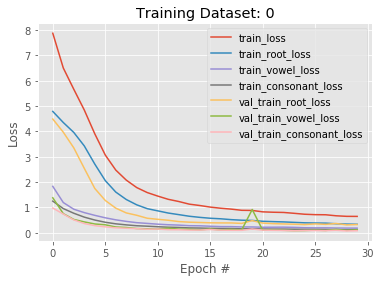

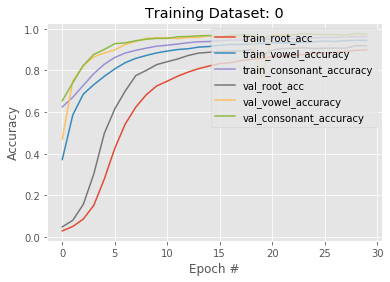

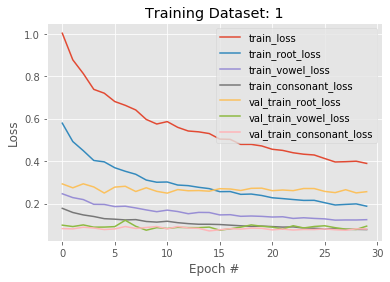

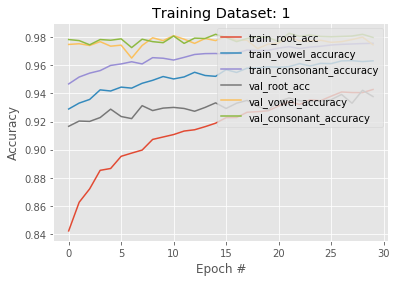

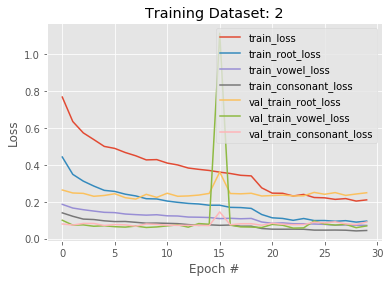

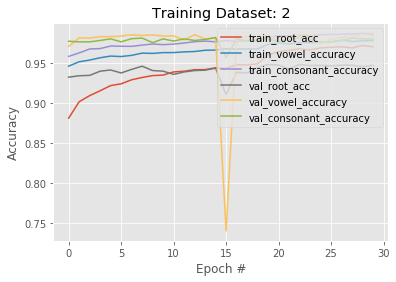

IndexError: list index out of range

In [30]:
%matplotlib inline
def plot_loss(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_3_loss'], label='train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_4_loss'], label='train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['dense_5_loss'], label='train_consonant_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_loss'], label='val_train_root_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_loss'], label='val_train_vowel_loss')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_loss'], label='val_train_consonant_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_acc(his, epoch, title):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['dense_3_accuracy'], label='train_root_acc')
    plt.plot(np.arange(0, epoch), his.history['dense_4_accuracy'], label='train_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['dense_5_accuracy'], label='train_consonant_accuracy')
    
    plt.plot(np.arange(0, epoch), his.history['val_dense_3_accuracy'], label='val_root_acc')
    plt.plot(np.arange(0, epoch), his.history['val_dense_4_accuracy'], label='val_vowel_accuracy')
    plt.plot(np.arange(0, epoch), his.history['val_dense_5_accuracy'], label='val_consonant_accuracy')
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.show()
for dataset in range(4):
    plot_loss(histories[dataset], epochs, f'Training Dataset: {dataset}')
    plot_acc(histories[dataset], epochs, f'Training Dataset: {dataset}')

In [31]:
del histories
gc.collect()

22719

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [48]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [32]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [41]:
components = ['consonant_diacritic', 'grapheme_root', 'vowel_diacritic']
target=[] # model predictions placeholder
row_id=[] # row_id place holder
for i in range(4):
    print(i)
    df_test_img = pd.read_parquet('bengaliai-cv19/test_image_data_{}.parquet'.format(i)) 
    df_test_img.set_index('image_id', inplace=True)

    X_test = resize(df_test_img, need_progress_bar=False)/255
   
    X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
    print(X_test.shape)
    
    preds = model.predict(X_test)

    for i, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[i], axis=1)

    for k,id in enumerate(df_test_img.index.values):  
        for i,comp in enumerate(components):
            id_sample=id+'_'+comp
            row_id.append(id_sample)
            target.append(preds_dict[comp][k])
    del df_test_img
    del X_test
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)
from datetime import datetime

df_sample.to_csv('submission_baseline_CNN_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.csv', index=False)

df_sample.head()


0
(3, 128, 128, 1)
1


KeyboardInterrupt: 

In [44]:
pd.read_csv('bengaliai-cv19/test.csv')

,row_id,image_id,component
0,Test_0_consonant_diacritic,Test_0,consonant_diacritic
1,Test_0_grapheme_root,Test_0,grapheme_root
2,Test_0_vowel_diacritic,Test_0,vowel_diacritic
3,Test_1_consonant_diacritic,Test_1,consonant_diacritic
4,Test_1_grapheme_root,Test_1,grapheme_root
5,Test_1_vowel_diacritic,Test_1,vowel_diacritic
6,Test_2_consonant_diacritic,Test_2,consonant_diacritic
7,Test_2_grapheme_root,Test_2,grapheme_root
8,Test_2_vowel_diacritic,Test_2,vowel_diacritic
9,Test_3_consonant_diacritic,Test_3,consonant_diacritic
